In [92]:
import os.path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re
import matplotlib.ticker as mticker
from matplotlib.dates import HourLocator, DateFormatter,DayLocator,MonthLocator
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima

from datetime import datetime

from pandas import read_csv

import pmdarima as pm
from pmdarima.arima import ADFTest
from pmdarima.model_selection import train_test_split

from sklearn.metrics import mean_squared_error

In [36]:
data = read_csv("2021-all-meter.csv").drop("Unnamed: 0", axis = 1)
display(data)

,AMI Meter ID,date,16335457,18762999,230156289,56068032,56073008,56210792,56464971,66675284,...,98828750,98923621,98923641,98923648,98923655,98923661,98923662,98923663,Residential,Total
0,2021-03-21 00:00:00,2021-03-21 00:30:00,104.192,28.649,46.68,13.104,9.195,373.44,19.656,5.491,...,20.640,0.324,15.228,16.212,47.430,51.60,16.35,21.624,67808.216,71482.267
1,2021-03-21 00:30:00,2021-03-21 01:00:00,104.848,28.578,51.60,15.728,9.810,373.44,20.640,6.278,...,21.624,0.324,14.736,15.228,39.198,46.68,16.35,17.688,67808.216,71395.502
2,2021-03-21 01:00:00,2021-03-21 01:30:00,106.160,29.929,55.29,14.416,8.580,375.96,19.656,7.853,...,9.338,0.160,15.228,14.244,40.976,44.22,14.30,18.180,68586.253,72266.724
3,2021-03-21 01:30:00,2021-03-21 02:00:00,104.192,29.488,50.37,16.384,11.040,378.36,18.672,6.278,...,9.418,0.324,14.736,14.244,42.165,44.22,16.35,16.704,68586.253,72069.140
4,2021-03-21 02:00:00,2021-03-21 02:30:00,104.192,28.645,52.83,15.728,12.270,375.96,20.640,4.704,...,8.928,0.324,15.228,16.212,50.782,46.68,18.40,18.180,71152.560,74632.641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8395,2021-09-27 21:30:00,2021-09-27 22:00:00,104.192,22.003,11.04,14.416,13.422,766.68,24.084,3.917,...,21.624,0.488,42.264,26.040,28.374,88.44,18.40,22.116,72763.262,76780.806
8396,2021-09-27 22:00:00,2021-09-27 22:30:00,104.192,22.214,9.81,11.136,12.476,727.44,22.608,3.917,...,21.132,0.324,40.296,22.608,29.898,88.44,16.35,20.148,61979.926,65924.937
8397,2021-09-27 22:30:00,2021-09-27 23:00:00,104.192,22.598,11.04,10.480,10.888,604.56,23.592,3.130,...,16.704,0.324,38.820,21.132,27.843,85.98,16.35,20.148,61979.926,65741.525
8398,2021-09-27 23:00:00,2021-09-27 23:30:00,104.192,22.598,9.81,7.856,9.106,668.40,20.148,3.130,...,15.720,0.488,35.880,15.720,24.676,85.98,14.30,19.656,51223.651,54984.815


<AxesSubplot: >

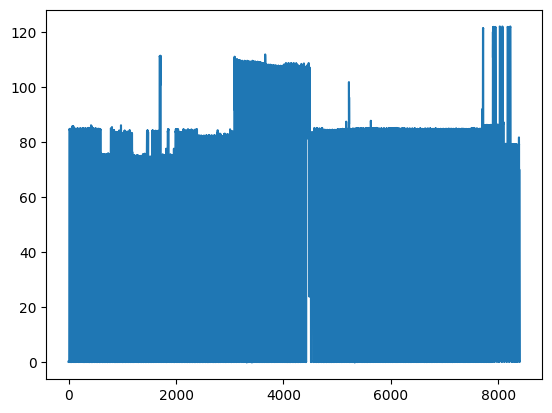

In [37]:
data["98923621"].plot()

In [74]:
adf_test = ADFTest(alpha = 0.05)
adf_test.should_diff(data["18762999"])

(0.01, False)

0      2021-03-21 00:00:00
1      2021-03-21 00:30:00
2      2021-03-21 01:00:00
3      2021-03-21 01:30:00
4      2021-03-21 02:00:00
              ...         
495    2021-03-31 07:30:00
496    2021-03-31 08:00:00
497    2021-03-31 08:30:00
498    2021-03-31 09:00:00
499    2021-03-31 09:30:00
Name: AMI Meter ID, Length: 500, dtype: object

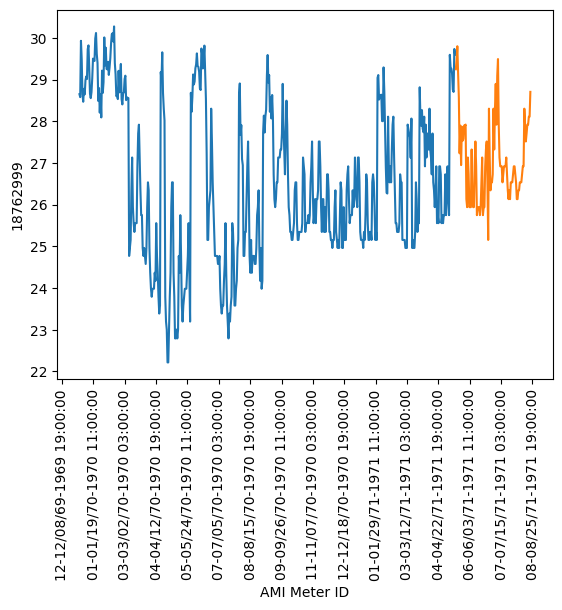

In [75]:
train = data["18762999"][:500]
traind = data["AMI Meter ID"][:500]
test = data["18762999"][500:600]
testd = data["AMI Meter ID"][500:600]
plot = sns.lineplot(y=train,x=traind)
plt.plot(testd,test)
plt.xticks(data["AMI Meter ID"][:600],rotation = 90)
plot.xaxis.set_major_locator(HourLocator(interval=1000))
plot.xaxis.set_major_formatter(DateFormatter('%m-%D-%Y %H:%M:%S'))

traind

In [95]:
arima_model = auto_arima(train, start_p=0, start_q=0,
                        test='adf',       # use adftest to find optimal 'd'
                        max_p=5, max_q=5, # maximum p and q
                        m=1,              # frequency of series 2* 24 for 30 minutes
                        d=0,           # let model determine 'd'
                        seasonal=False,   # No Seasonality
                        start_P=0, 
                        D=0, 
                        trace=True,
                        error_action='ignore',  
                        suppress_warnings=True, 
                        stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4701.124, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=4037.286, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1285.436, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.35 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1285.310, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=3476.613, Time=0.10 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.47 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=1278.408, Time=0.10 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=inf, Time=0.29 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.68 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=1268.517, Time=0.47 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=2718.701, Time=0.74 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=1265.748, Time=0.61 sec
 ARIMA(3,0,4)(0,0,0)[0]             : AIC=1263.272, Time=0

In [96]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  500
Model:               SARIMAX(4, 0, 3)   Log Likelihood                -616.154
Date:                Mon, 21 Aug 2023   AIC                           1250.308
Time:                        21:13:41   BIC                           1288.239
Sample:                             0   HQIC                          1265.192
                                - 500                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4537     13.270      0.034      0.973     -25.556      26.463
ar.L1          1.8456     47.673      0.039      0.969     -91.592      95.283
ar.L2         -0.6372    117.831     -0.005      0.996    -231.582     230.308
ar.L3         -0.6600    103.967     -0.006      0.995    -204.432     203.112
ar.L4          0.4346     33.312      0.013      0.990     -64.855      65.724
ma.L1         -0.9161     47.690     -0.019      0.985     -94.387      92.555
ma.L2         -0.2768     73.545     -0.004      0.997    -144.422     143.869
ma.L3          0.4249     32.645      0.013      0.990     -63.558      64.408
sigma2         0.6868      0.028     24.306      0.000       0.631       0.742
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):              2324.72
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               0.79   Skew:                             1.39
Prob(H) (two-sided):                  0.12   Kurtosis:                        13.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [97]:
arima_model.fit(train)

ARIMA(order=(4, 0, 3), scoring_args={}, suppress_warnings=True)

In [98]:
prediction = pd.DataFrame(arima_model.predict(n_periods = 100), index = test.index)
prediction.columns = ['predicted_sales']
prediction

,predicted_sales
500,29.302208
501,29.056580
502,28.873970
503,28.751744
504,28.676951
...,...
595,26.717834
596,26.716729
597,26.715678
598,26.714678


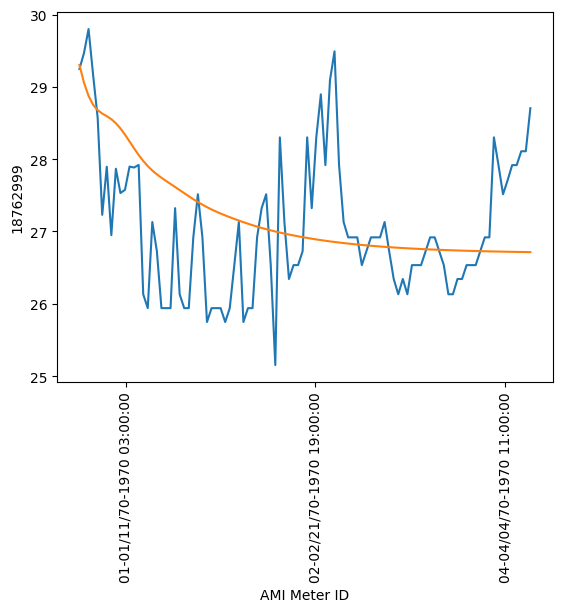

In [99]:
plot2 = sns.lineplot(y=test,x=testd)
plt.plot(testd,prediction)
plt.xticks(data["AMI Meter ID"][500:600],rotation = 90)
plot2.xaxis.set_major_locator(HourLocator(interval=1000))
plot2.xaxis.set_major_formatter(DateFormatter('%m-%D-%Y %H:%M:%S'))

In [100]:
valdata = prediction.copy()
valdata["test"] = test
valdata

,predicted_sales,test
500,29.302208,29.247
501,29.056580,29.468
502,28.873970,29.799
503,28.751744,29.164
504,28.676951,28.571
...,...,...
595,26.717834,27.917
596,26.716729,27.917
597,26.715678,28.109
598,26.714678,28.109


<AxesSubplot: xlabel='test', ylabel='predicted_sales'>

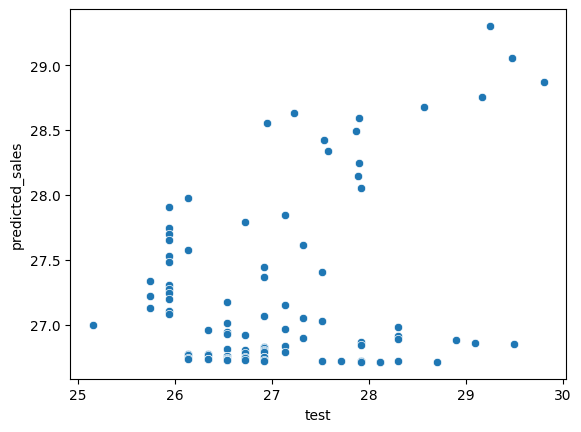

In [101]:
sns.scatterplot(valdata,y="predicted_sales", x="test")

In [102]:
mean_squared_error(valdata["predicted_sales"], valdata["test"])

0.9872064215753789